# Practical Bayesian Optimization of Machine Learning Algorithm

**Project Authors**: Vincent LE MEUR, Thomas Levy, Timothée Watrigant

## Implementation

### Context

We initially studied the author's implementation of the article called [Spearmint](https://github.com/JasperSnoek/spearmint).

We encountered the following difficulties:
* Old implementation, no longer updated and based on Python2: Python3 is now the main Python version.
* Libraries are difficult to integrate on Windows and Mac: We had to run Spearmint on a Linux virtual machine (Ubuntu 16.04).

In the end, this implementation became complex to use and extend, especially in a Python Notebook.

We therefore studied another implementation (see https://github.com/thuijskens/bayesian-optimization) which we adapted for our study.

### Our Implementation
In our implementation, we applied a Gaussian process with the ARD 5/2 kernel and the Expected Improvement acquisition function.
For simplicity, we did not use parallelization.

We applied this optimization algorithm to a multiclass classification problem.
We chose the famous iris dataset.

We optimized two hyperparameters for two Machine Learning algorithms from the scikit-learn library:
      SVM classifier (SVC) and Stochastic Gradient Descent classifier (SGDClassifier with loss='hinge', which corresponds to a linear SVM algorithm).

For SGDClassifier, the two hyperparameters are:
- l1_ratio, an elasticity parameter
- alpha, a regularization constant

For SVC, the two hyperparameters are:
- C, a penalty term in the error function
- $\gamma$, a kernel-specific coefficient

In addition to the iris dataset, we also used the sklearn function "make_classification" to randomly generate a new dataset.

Additionally, we used sklearn functions for defining the Matérn 5/2 kernel and for the Gaussian process.

We start by defining useful functions for Bayesian optimization (kernel, expected improvement, determination of the next evaluation point), then functions for displaying figures.

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn import datasets
from matplotlib import rc
%matplotlib inline

### Definition of the "Expected Improvement" acquisition function
Parameters:
* x: array type, point to evaluate
* gaussian_process: The previously trained Gaussian process on the hyperparameters
* evaluated_loss: Numpy array containing previously evaluated loss function values
* greater_is_better: Boolean indicating whether to maximize or minimize the loss function
* n_params: int indicating the dimension of the hyperparameters

In [2]:
def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


### Function to determine the next acquisition point:
Params:
* acquisition_func: acquisition function to optimize
* gaussian_process: The previously trained Gaussian process on the hyperparameters
* evaluated_loss: Numpy array containing previously evaluated loss function values
* greater_is_better: Boolean indicating whether to maximize or minimize the loss function
* bounds: Tuple indicating the bounds for the L-BFGS optimizer
* n_restarts: int indicating the number of iterations performed on the optimizer with different starting values

In [3]:
def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):

    # Initialisation : 
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))
        # Condition de changement d'hyperparamètres : 
        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x

### Function to optimize the loss function using a Gaussian process
Params:
* n_iters: int indicating the number of iterations to use
* sample_loss: function to optimize
* bounds: Array indicating the bounds of the loss function
* x0: array defining initial points to evaluate the loss function. If x0=None, these points are chosen randomly
* n_pre_samples: int indicating the number of initial points if x0=None
* gp_params: dictionary indicating the hyperparameters to pass to the Gaussian process
* random_search: Boolean indicating whether to use random search or L-BFGS optimization on the acquisition function
* alpha: double indicating the variance associated with the error term of the Gaussian process
* epsilon: double indicating the tolerance level for float evaluation

In [4]:
def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern(nu=5/2)
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Mise en place des hyperparamètres suivants : 
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Mise en place de la fonction de perte pour de nouveaux paramètres : 
        cv_score = sample_loss(next_sample)

        # Mise à jours des listes
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Mise à jour des sorties
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

### Functions to display results at each iteration
The following functions are used to create graphs to illustrate the optimization process.
The resulting graphs will show our different hyperparameters on the axes, with a color code corresponding to isovalues of the loss function and Expected Improvement, respectively.
Params:
* first_param_grid: Array containing the grid of points to display for the first parameter.
* sampled_params: Points for which the loss function value is calculated.
* sampled_loss: Loss function used
* first_iter: First iteration to display
* alpha: Error variance in the GP model
* greater_is_better: boolean indicating whether to maximize or minimize the loss function.
* true_y: array containing the true loss value for comparison display.
* second_param_grid: Array containing the grid of points to display for the second parameter.
* param_dims_to_plot: list of indices in `sampled_params` containing the first and second parameter.
* optimum: maximum value of the loss function

In [5]:
def plot_iteration(first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):
 

    # Create the GPMatern
    kernel = gp.kernels.Matern(nu=5/2)
    model = gp.GaussianProcessRegressor(kernel=kernel,
                                        alpha=alpha,
                                        n_restarts_optimizer=10,
                                        normalize_y=True)

    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])

        if second_param_grid is None:
            # 1-dimensional case: line plot
            mu, std = model.predict(first_param_grid[:, np.newaxis], return_std=True)
            ei = -1 * expected_improvement(first_param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=1)

            fig, ax1, ax2 = _plot_loss_1d(first_param_grid, sampled_params[:(i + 1), :], sampled_loss[:(i + 1)], mu, std, ei, sampled_params[i + 1, :], yerr=alpha, true_y=true_y)
        else:
            # Transform grids into vectors for EI evaluation
            param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

            mu, std = model.predict(param_grid, return_std=True)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=2)

            fig, ax1, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, sampled_params[:(i+1), param_dims_to_plot], sampled_loss, mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)

        if filepath is not None:
             plt.savefig('%s/bo_iteration_%d.png' % (filepath, i), bbox_inches='tight')


def _plot_loss_1d(x_grid, x_eval, y_eval, mu, std, ei, next_sample, yerr=0.0, true_y=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

    # Loss function plot
    ax1.plot(x_grid, mu, label = "GP mean")
    ax1.fill_between(x_grid, mu - std, mu + std, alpha=0.5)
    ax1.errorbar(x_eval, y_eval, yerr, fmt='ok', zorder=3, label="Observed values")
    ax1.set_ylabel("Function value f(x)")
    ax1.set_xlabel("x")

    if true_y is not None:
        ax1.plot(x_grid, true_y, '--', label="True function")

    # Acquisition function plot
    ax2.plot(x_grid, ei, 'r', label="Expected improvement")
    ax2.set_ylabel("Expected improvement (EI)")
    ax2.set_title("Next sample point is C = %.3f" % next_sample)
    ax2.axvline(next_sample)

    return fig, ax1, ax2

def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, next_sample, optimum=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("hyper-param1")
    ax1.set_ylabel("hyper-param2")

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("Mean estimate of loss surface for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("hyper-param1")
    ax2.set_ylabel("hyper-param2")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='red', s=150)

    return fig, ax1, ax2


## 1. SGDClassifier

We will now try to optimize the hyperparameters of the sklearn SGDClassifier algorithm with loss='hinge' on our iris dataset:

In [6]:
# Récupération des données
data,target = load_iris(True)
# On définit ici notre classifieur :
def sample_loss(params):
    return cross_val_score(SGDClassifier(alpha=10 **params[0], l1_ratio=params[1],loss='hinge'),
                           X=data, y=target, cv=3).mean()

We seek an optimal value for the hyperparameters, indicated by a red star on our future graphs.

In [7]:
# Espace dans lequel va évoluer nos hyperparamètres
alphas = np.linspace(-4,2,100)
l1_ratios = np.linspace(0,1,100)

# On définit une matrice regroupant toutes les combinaisons des deux variables précédentes
param_grid = np.array([[alpha, l1_ratio] for alpha in alphas for l1_ratio in l1_ratios])

# On calcule la perte associée à ces hyperparamètres
real_loss = [sample_loss(params) for params in param_grid]

# On détermine les hyperparamètres "optimaux"
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([-2.48484848,  0.91919192])

Below, we set up our Bayesian optimization:

In [8]:
# On détermine l'espace dans lequel évolue nos paramètres
bounds = np.array([[-4,2], [0,1]])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=1000)

We display the results obtained by Bayesian optimization for the loss function and Expected Improvement at each iteration:

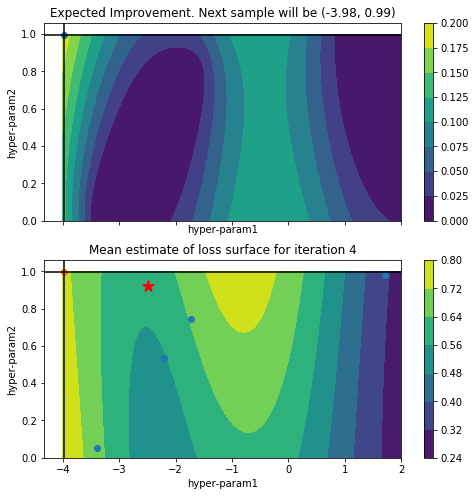

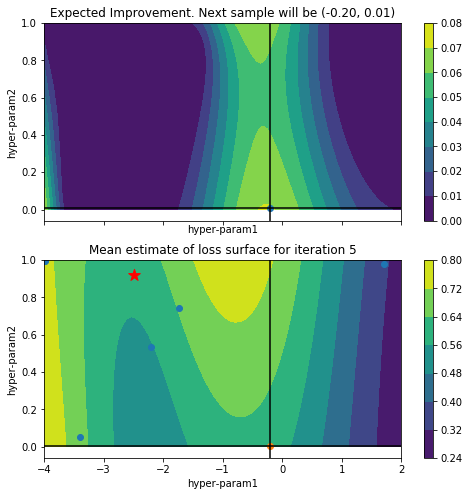

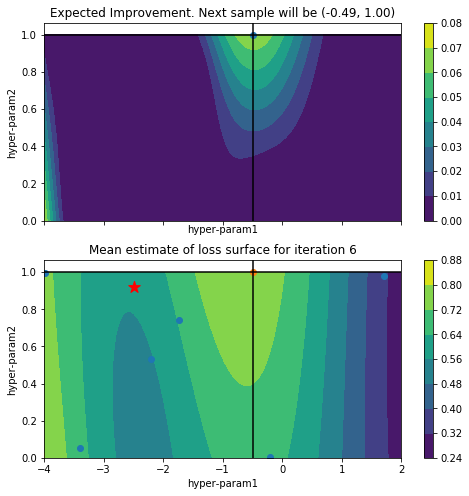

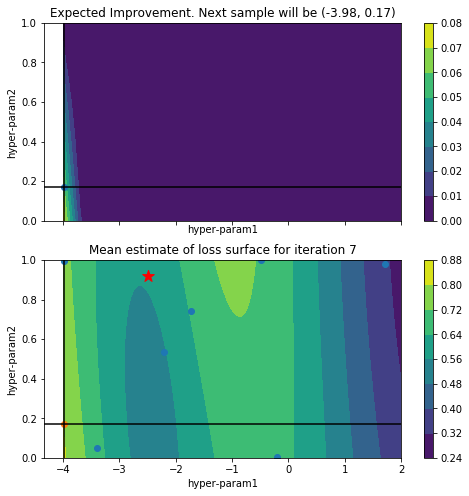

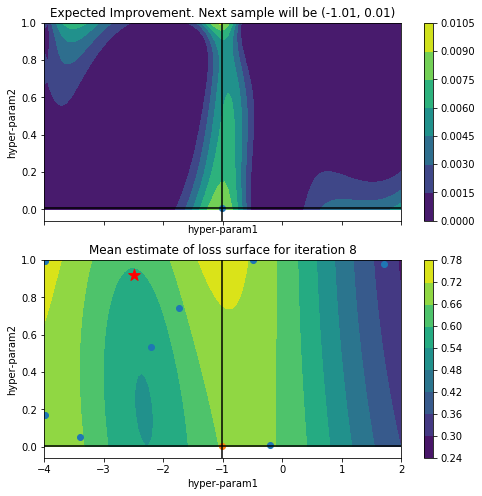

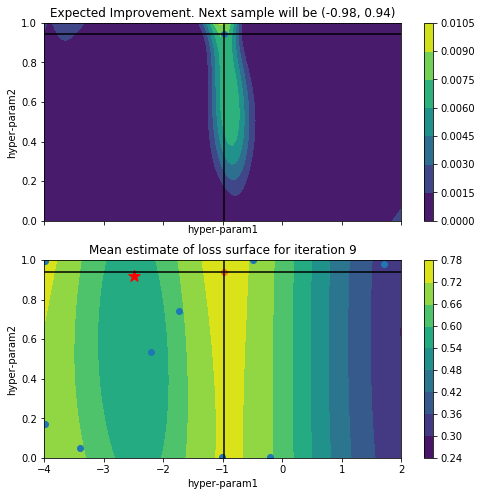

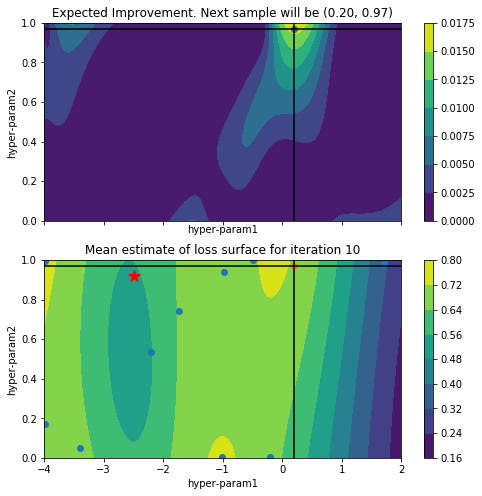

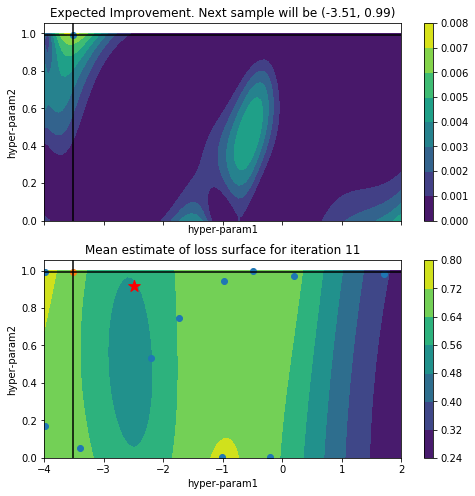

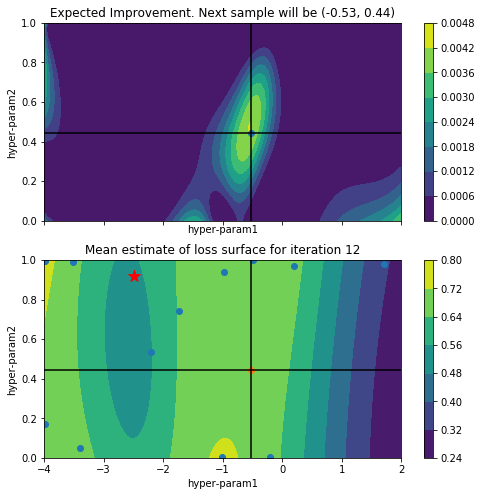

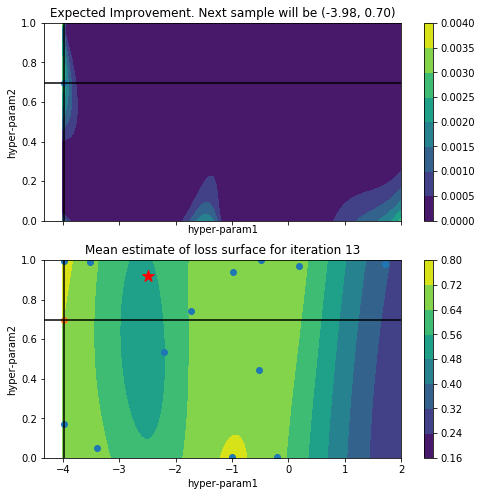

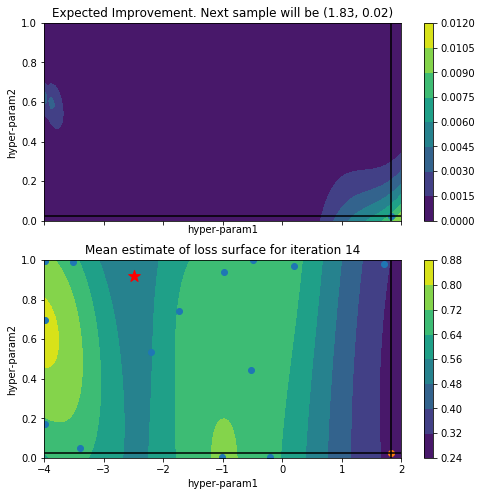

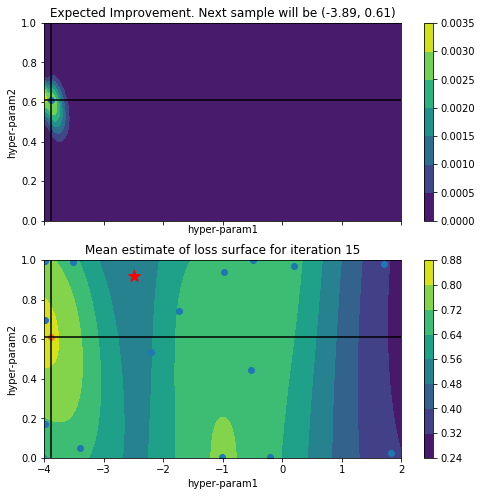

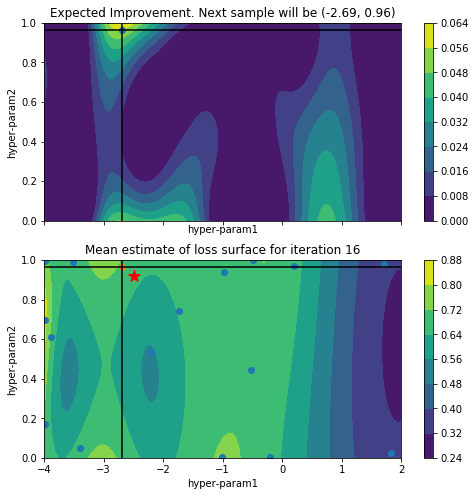

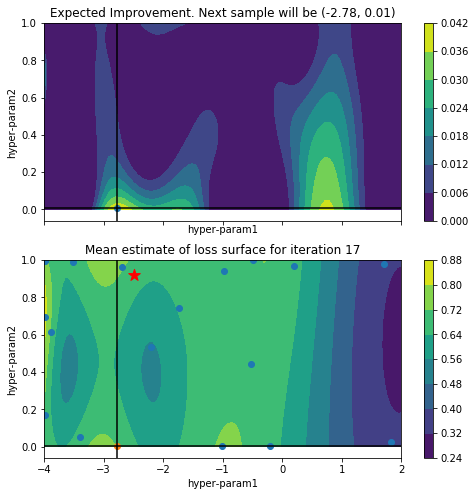

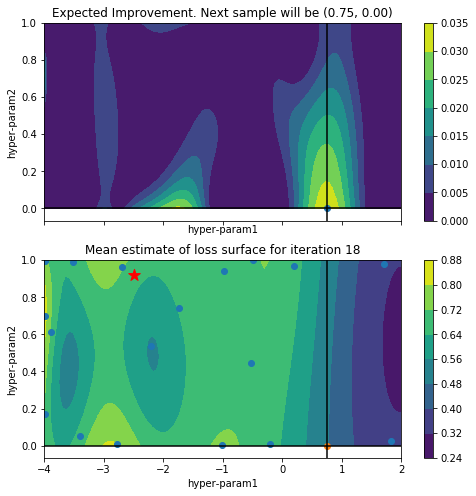

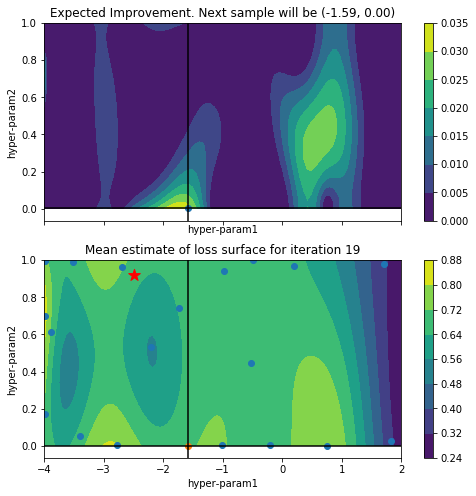

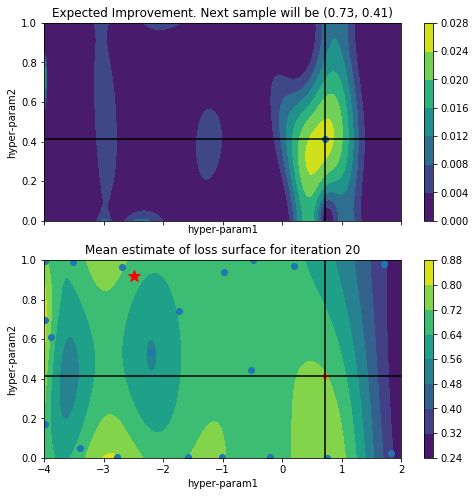

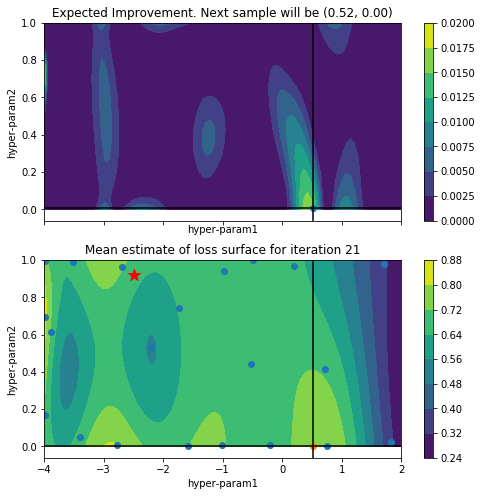

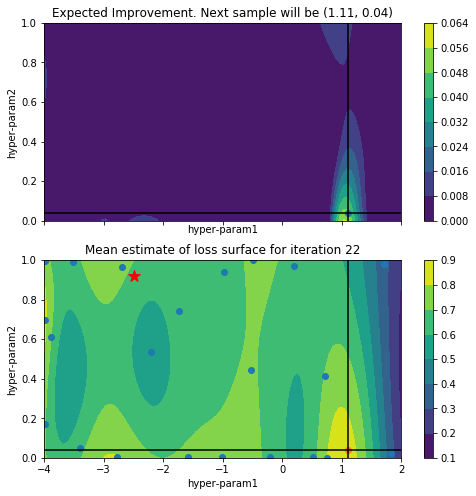

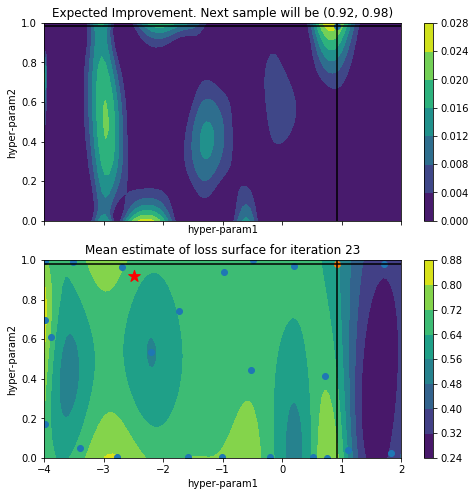

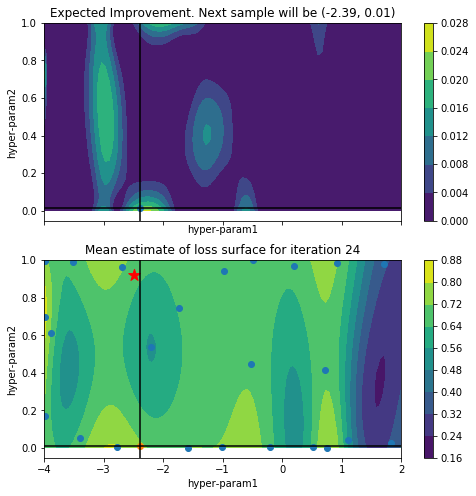

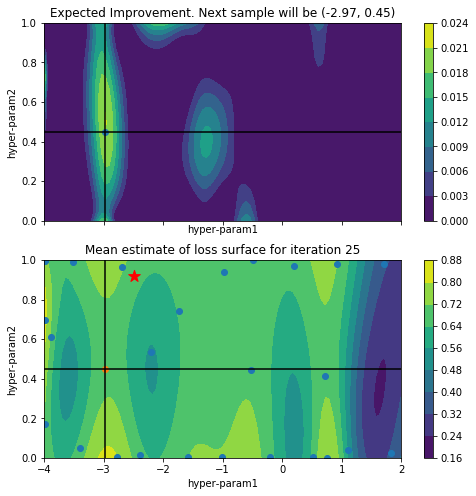

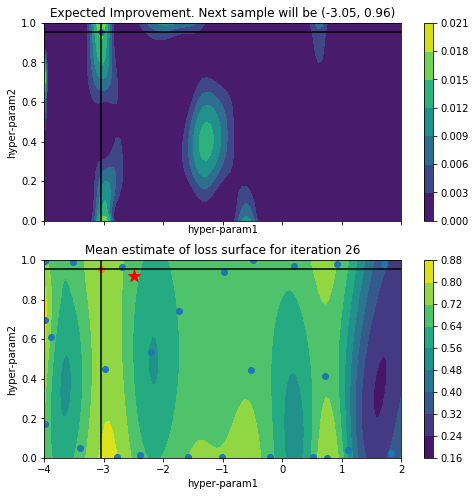

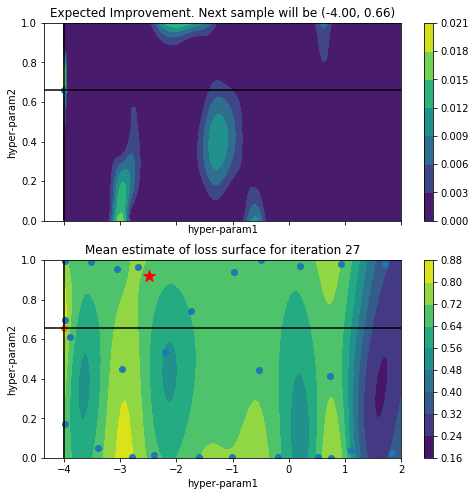

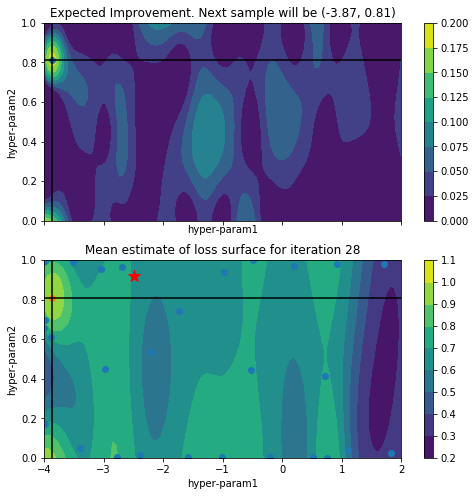

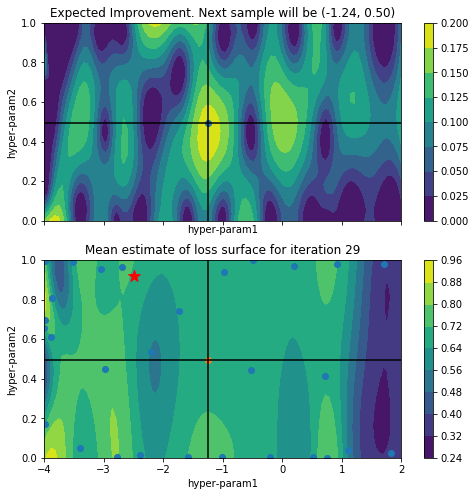

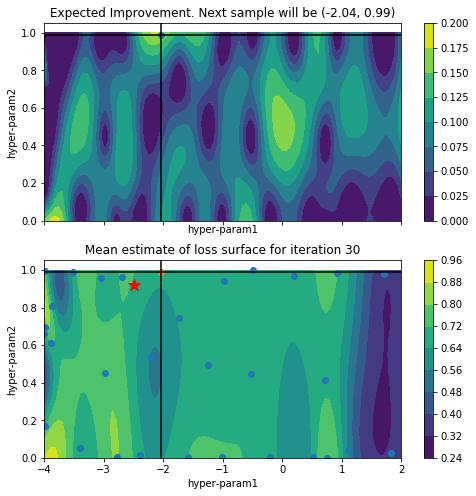

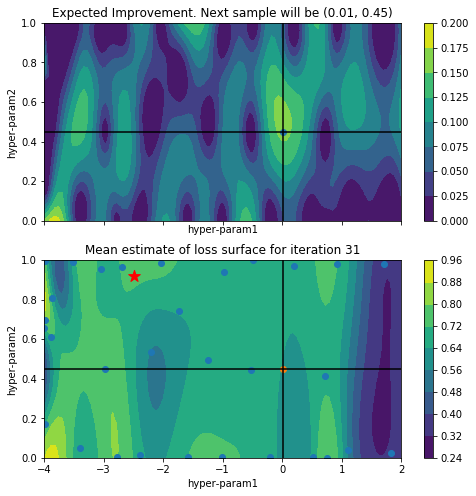

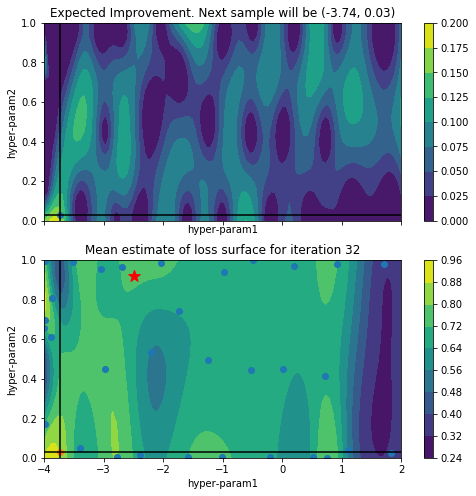

In [9]:
rc('text', usetex=False)
plot_iteration(alphas, xp, yp, first_iter=3, second_param_grid=l1_ratios, optimum=maximum, filepath='.')

We observe that the algorithm does not tend toward the optimal point (red star) determined previously. However, the optimum obtained in the last iterations is in a rather low isovalue zone, which supports the convergence of the algorithm toward optimal values.

## 2. SVM Classifier (SVC)

We now apply our algorithm with the SVC model.

In [10]:
def sample_loss2(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, cv=3).mean()

We seek an optimal value for the hyperparameters, indicated by a red star on our future graphs:

In [11]:
# Espace dans lequel va évoluer nos hyperparamètres
Cs = np.linspace(5, -1, 25)
gammas = np.linspace(-1, -7, 20)

# On définit une matrice regroupant toutes les combinaisons des deux variables précédentes
param_grid = np.array([[C, gamma] for gamma in gammas for C in Cs])

# On calcule la perte associée à ces hyperparamètres
real_loss = [sample_loss2(params) for params in param_grid]

# On détermine les hyperparamètres "optimaux"
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([ 2.75      , -2.89473684])

Below, we set up our Bayesian optimization:

In [12]:
# On détermine l'espace dans lequel évolue nos paramètres
bounds = np.array([[-1, 5], [-7, -1]])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss2, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

We display the results obtained by Bayesian optimization for the loss function and Expected Improvement at each iteration:

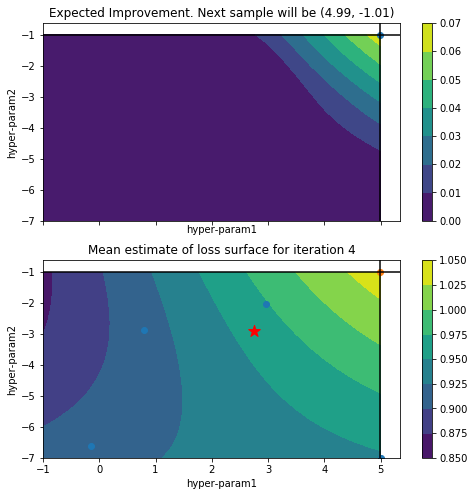

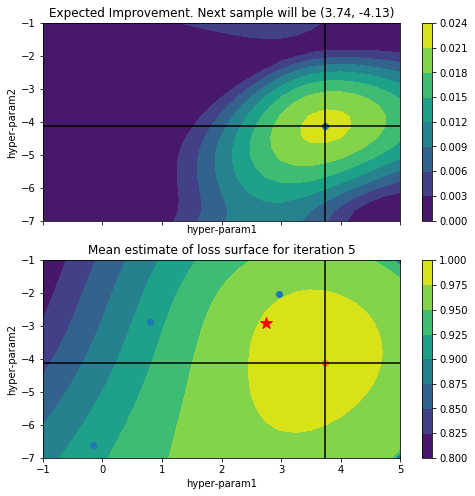

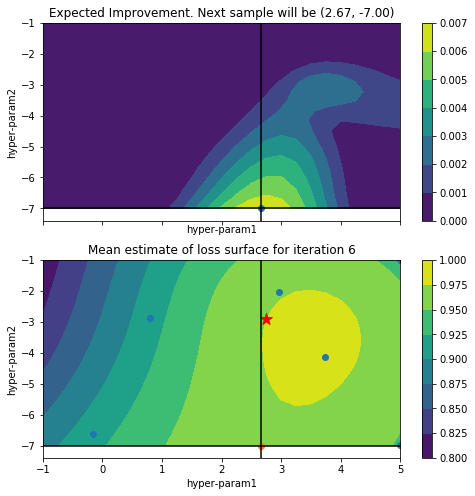

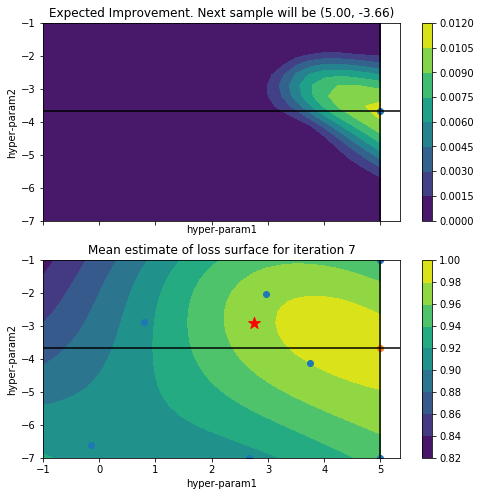

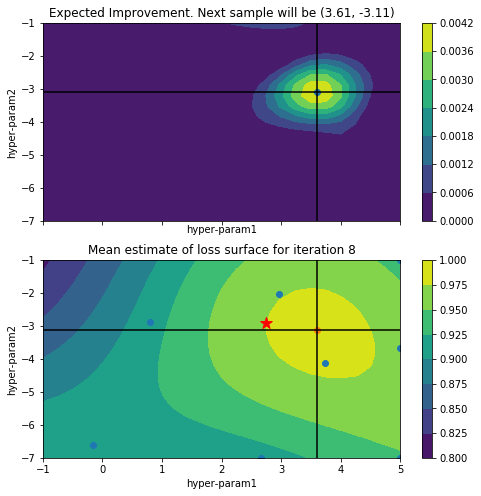

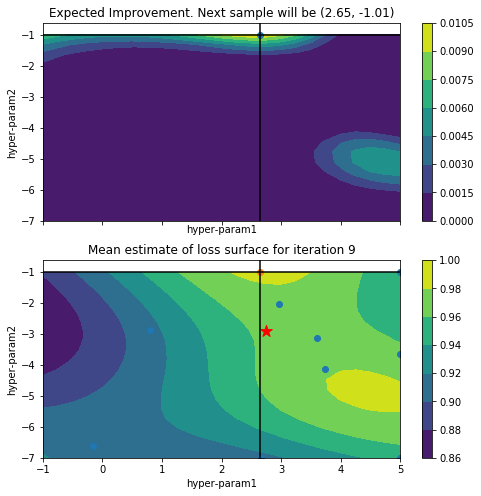

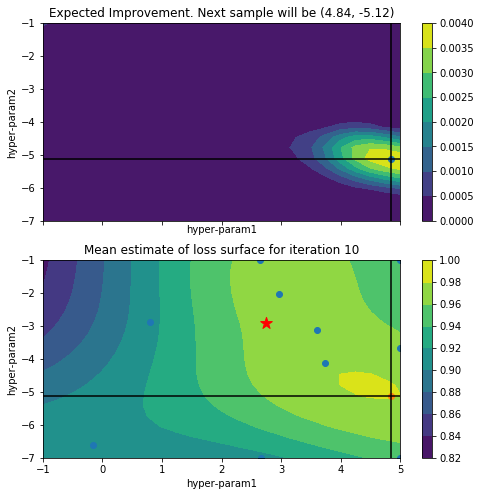

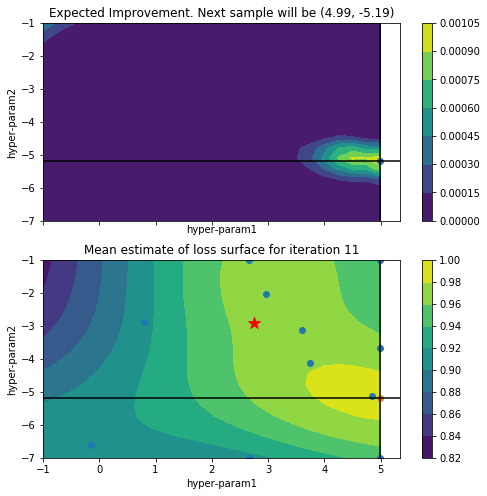

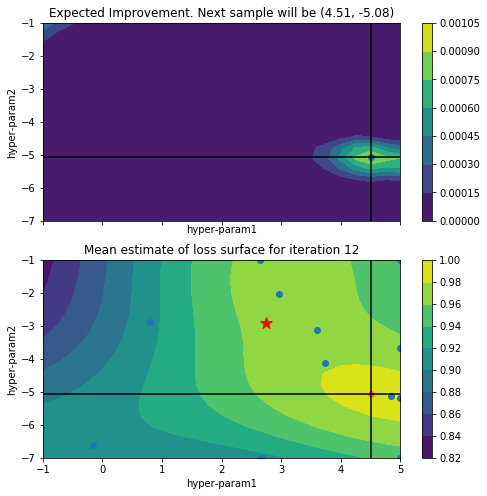

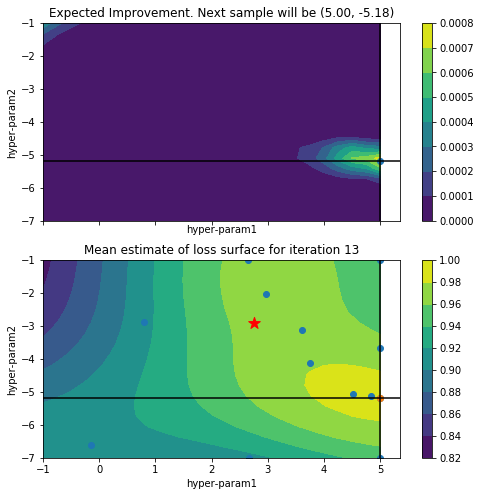

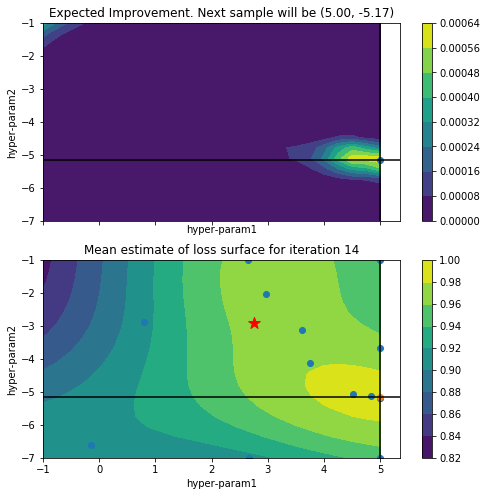

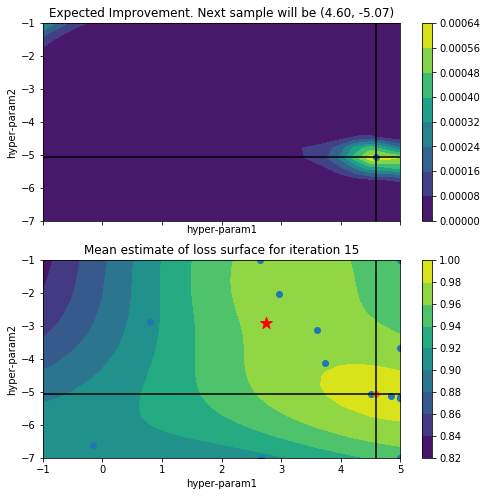

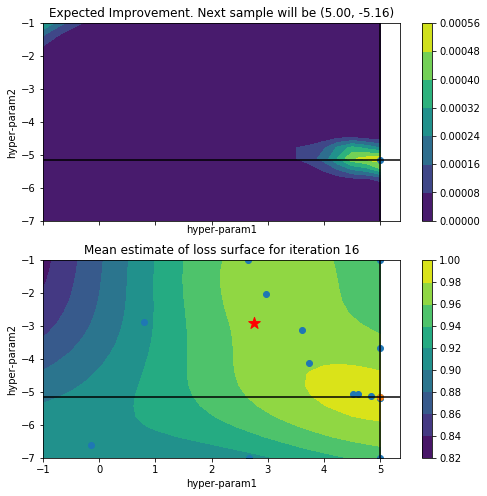

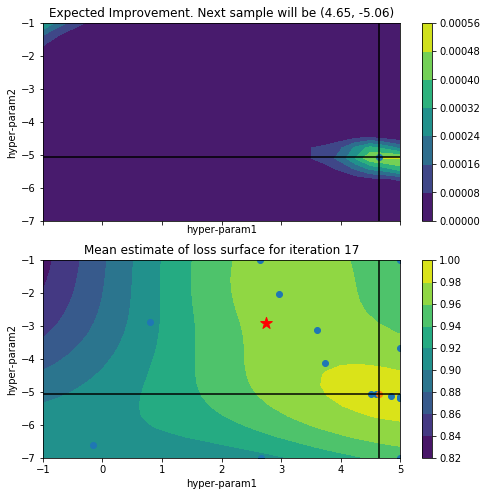

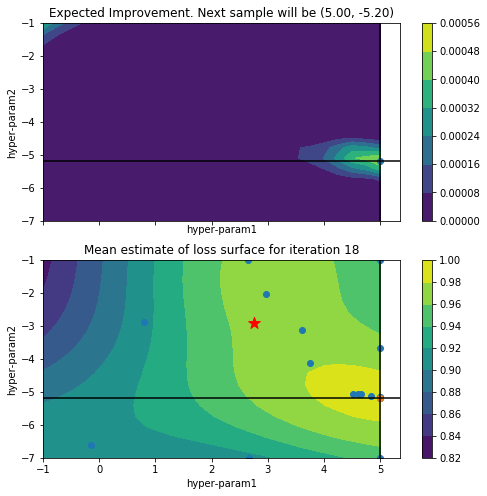

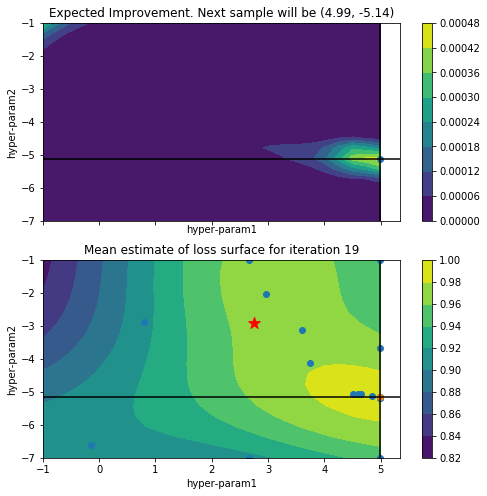

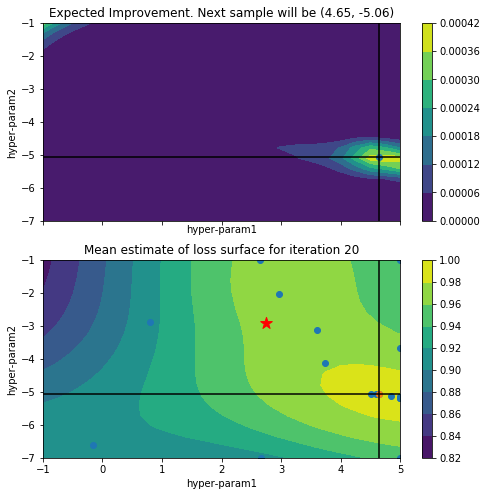

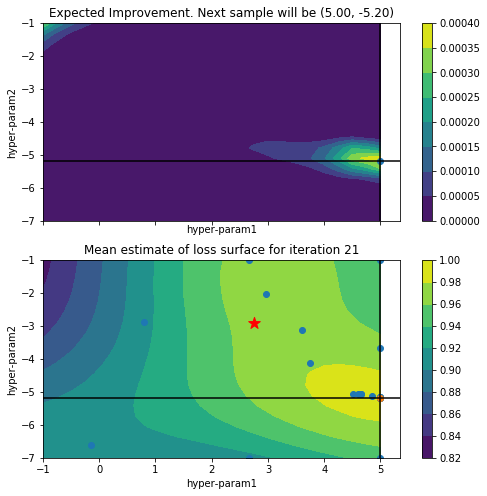

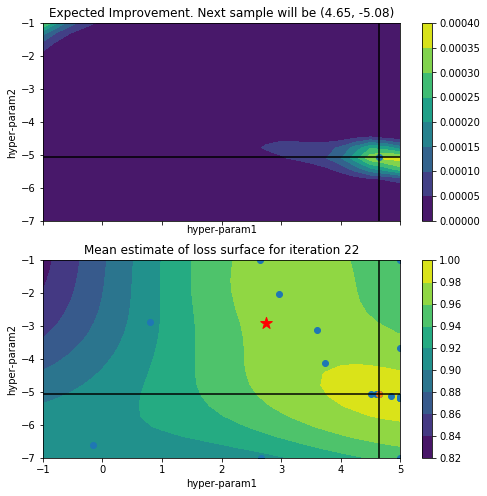

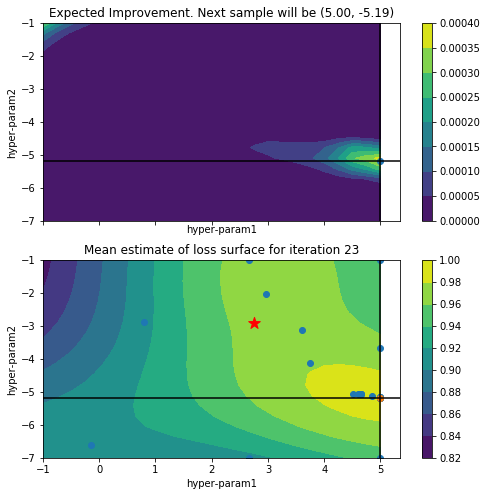

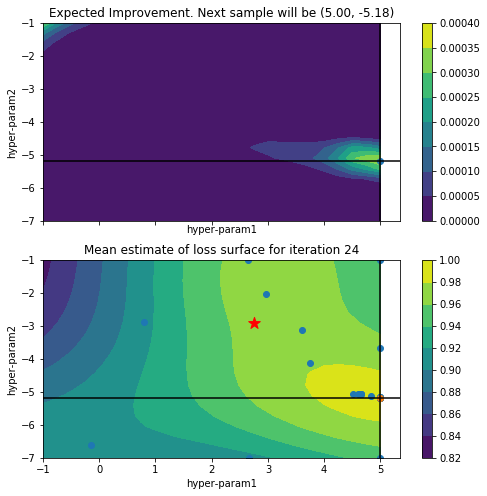

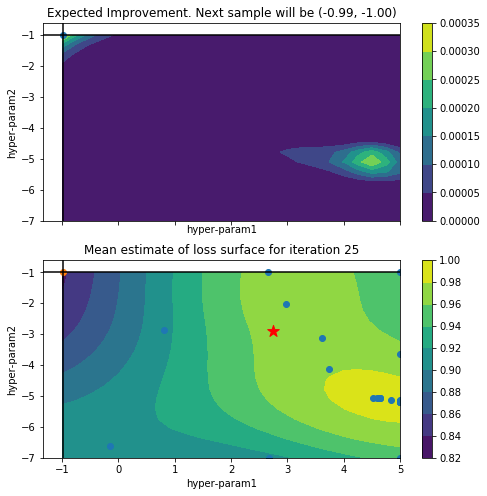

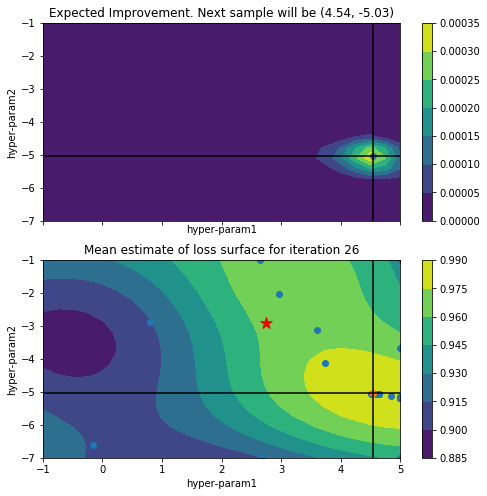

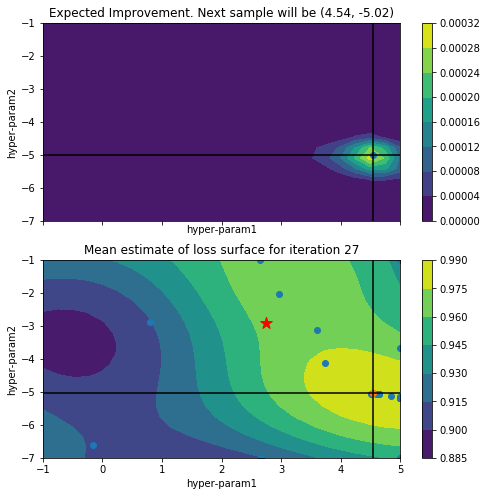

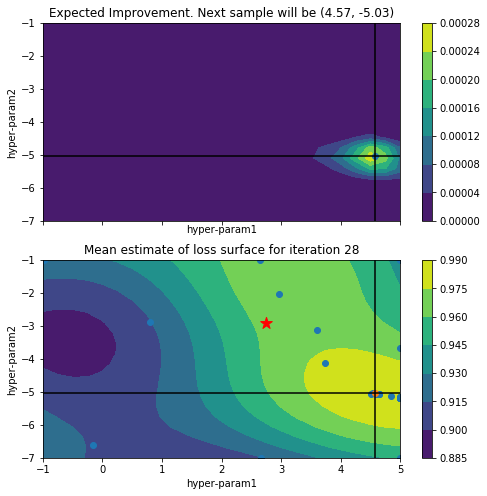

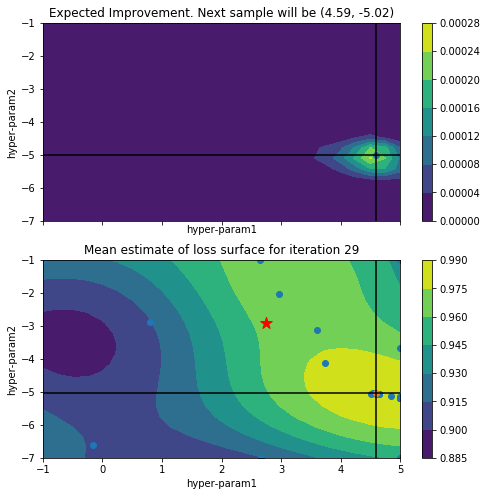

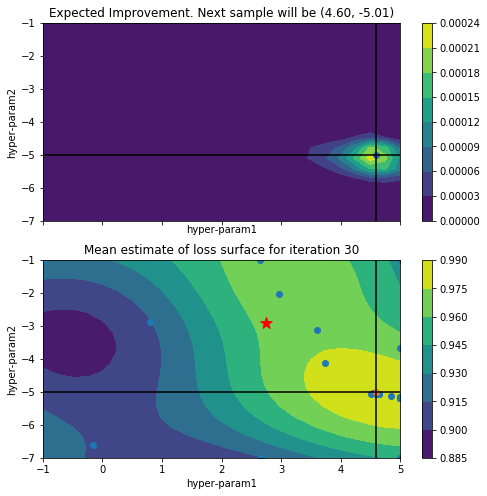

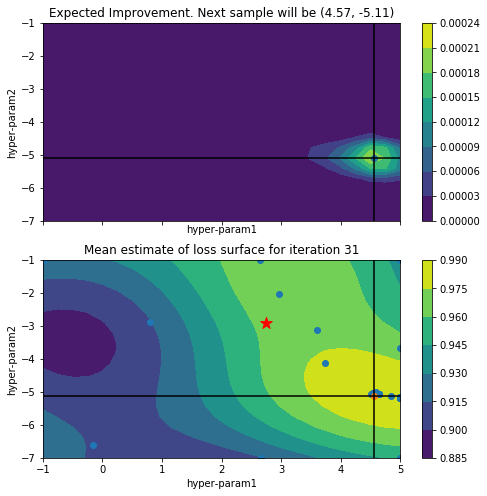

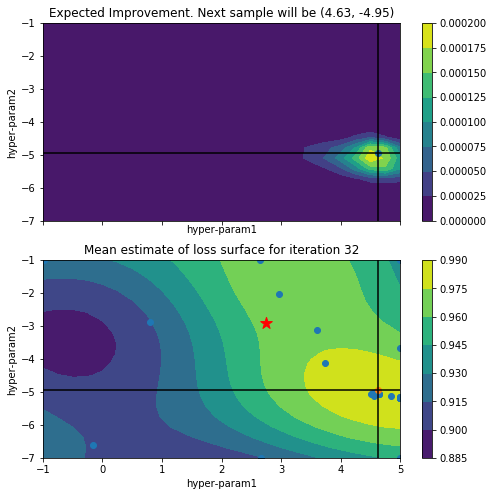

In [13]:
rc('text', usetex=False)

plot_iteration(Cs, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum, filepath='.')


Ici encore, l'algorithme se trouve dans une zone d'isovaleurs proche de notre objectif.

## 3. Utilisation d'un nouveau dataset de classification binaire (avec make_classification)

On créé cette fois un nouveau dataset sur lequel nous allons appliquer l'algorithme SVC

In [14]:
data, target = datasets.make_classification(n_samples=2000,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

In [15]:
def sample_loss3(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, cv=3, scoring='roc_auc').mean()

In [16]:
# Espace dans lequel va évoluer nos hyperparamètres
#Cs = np.linspace(5, -1, 25)
Cs = np.linspace(2, -4, 25)

#gammas = np.linspace(-1, -7, 20)
gammas = np.linspace(2, -4, 20)

# On définit une matrice regroupant toutes les combinaisons des deux variables précédentes
param_grid = np.array([[C, gamma] for gamma in gammas for C in Cs])

# On calcule la perte associée à ces hyperparamètres
real_loss = [sample_loss3(params) for params in param_grid]

# On détermine les hyperparamètres "optimaux"
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([ 0.25      , -2.10526316])

In [17]:
# On détermine l'espace dans lequel évolue nos paramètres
bounds = np.array([[-4, 2], [-4, 2]])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss3, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

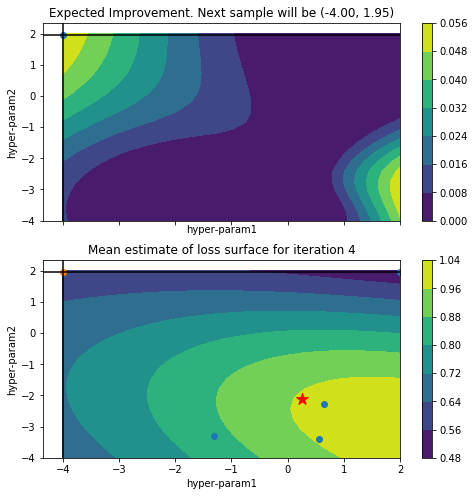

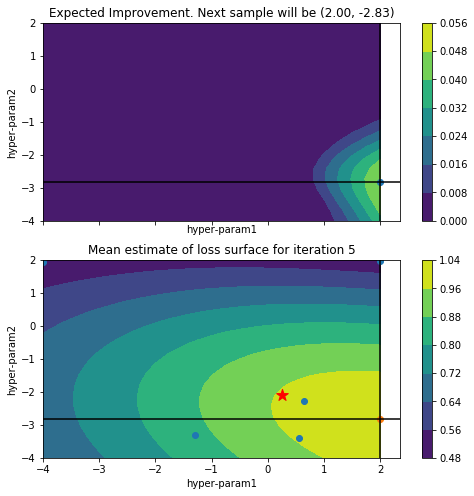

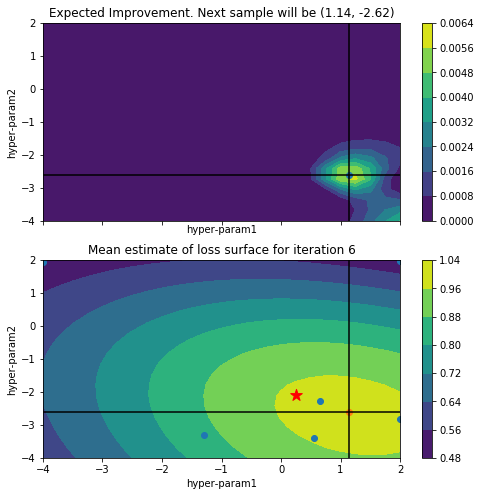

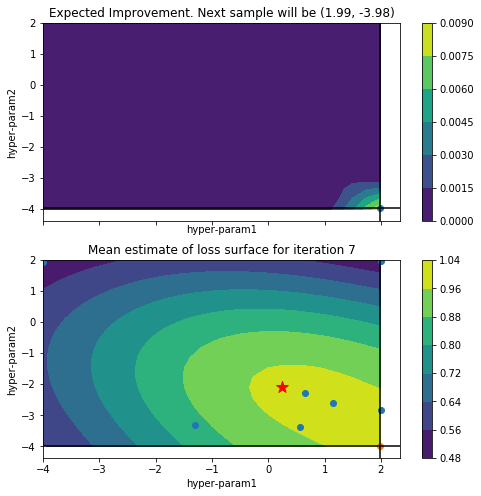

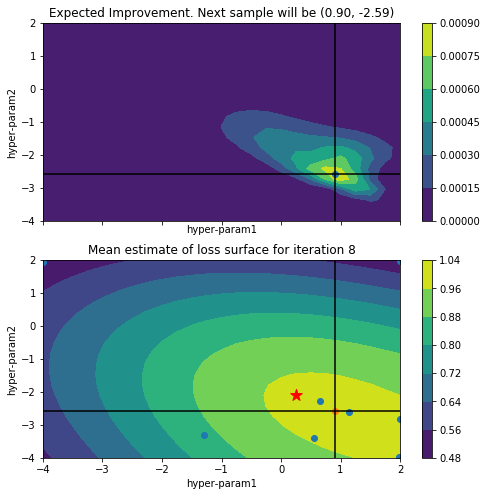

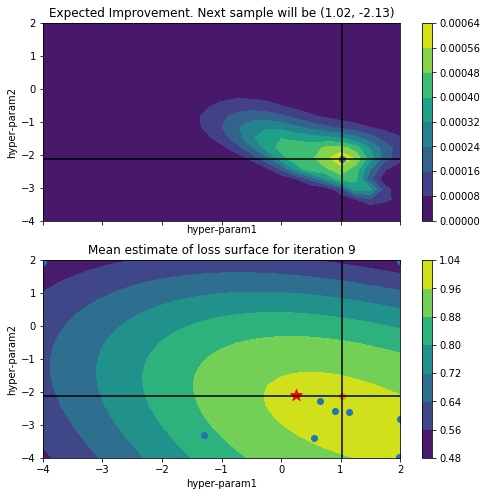

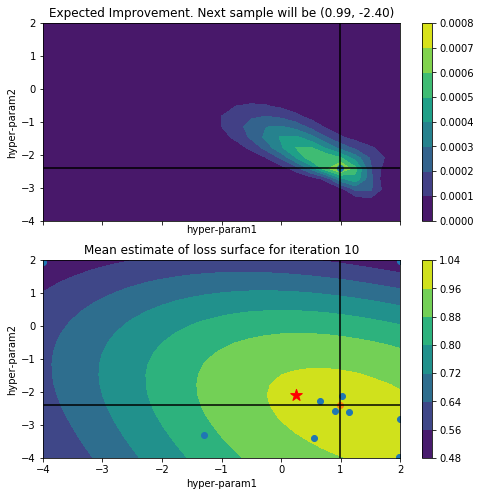

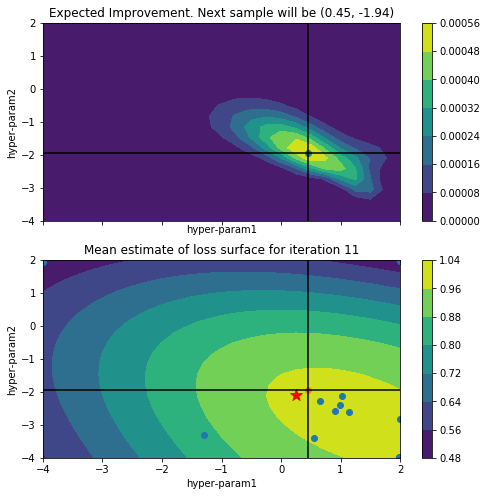

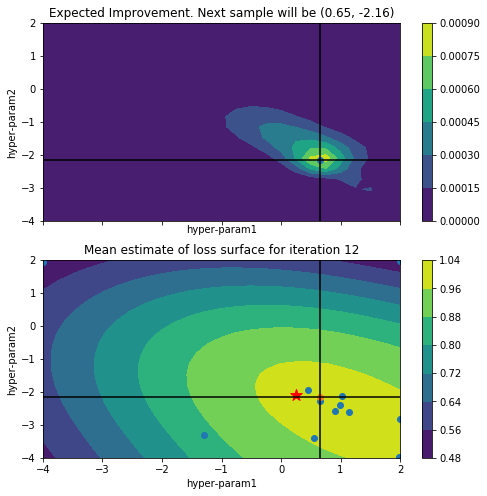

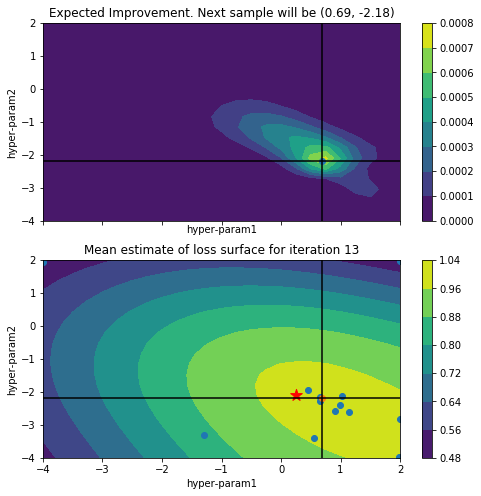

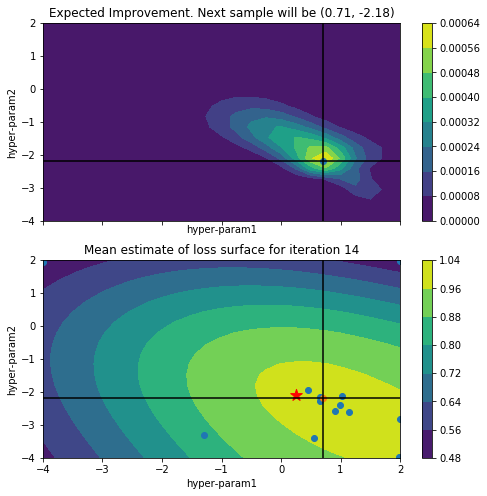

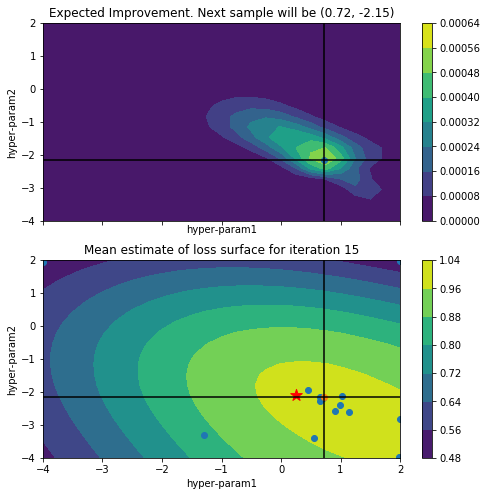

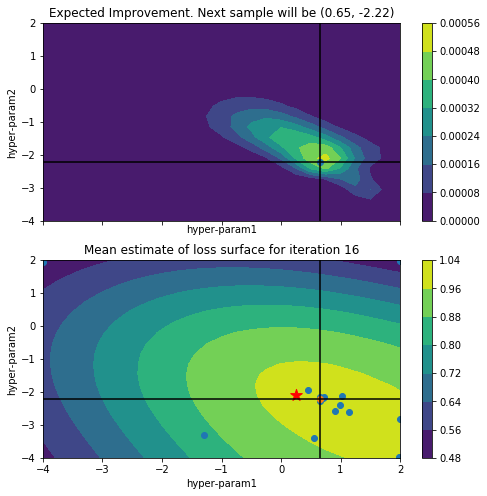

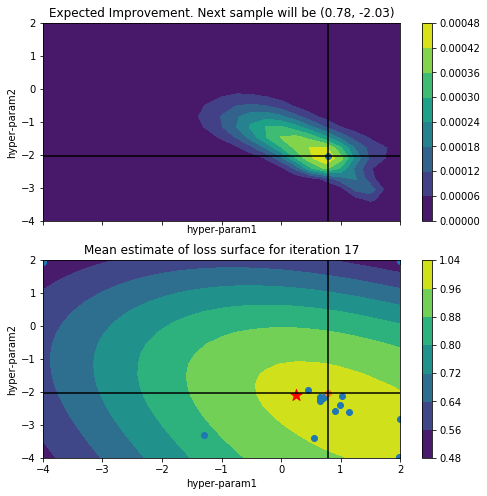

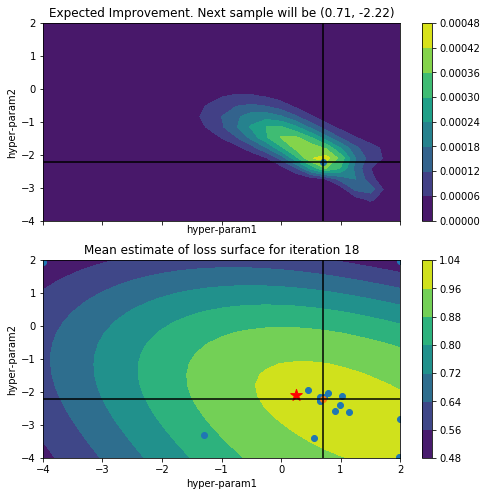

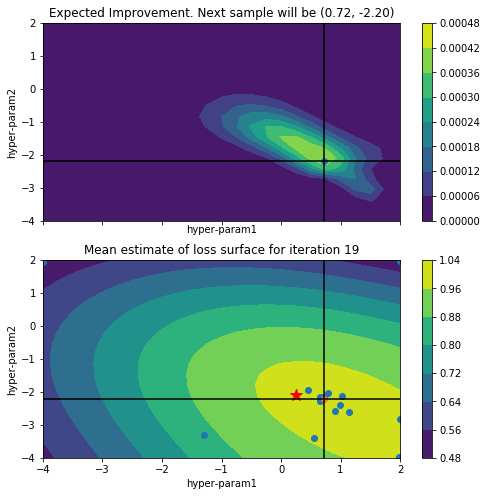

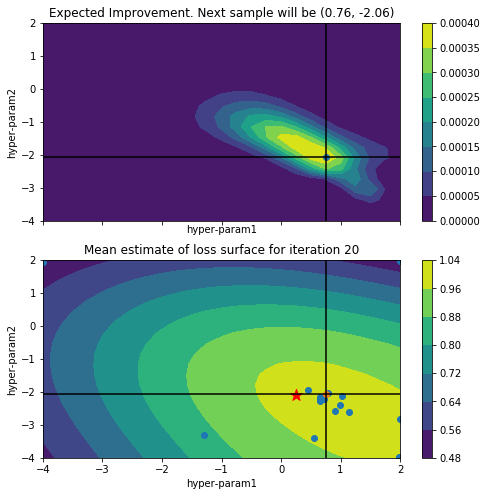

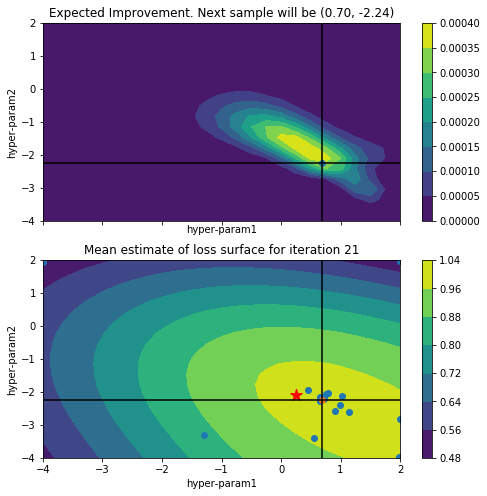

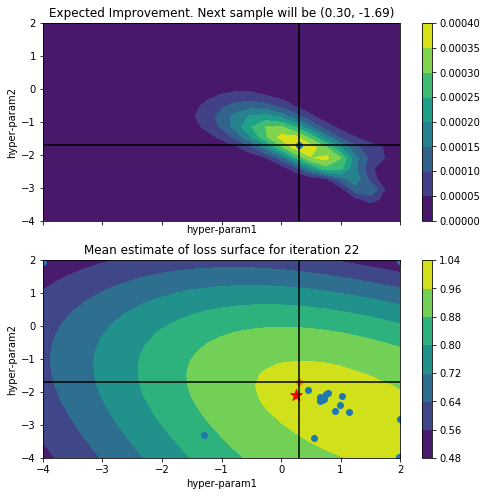

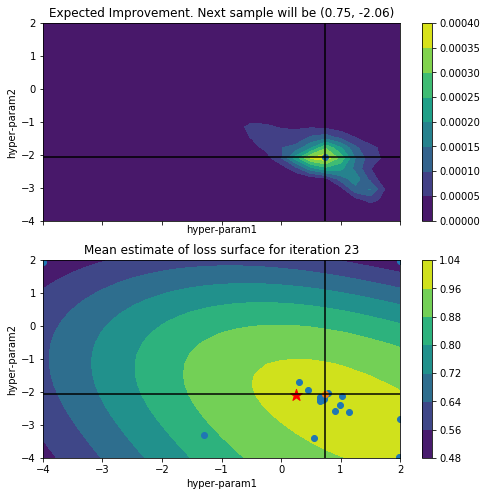

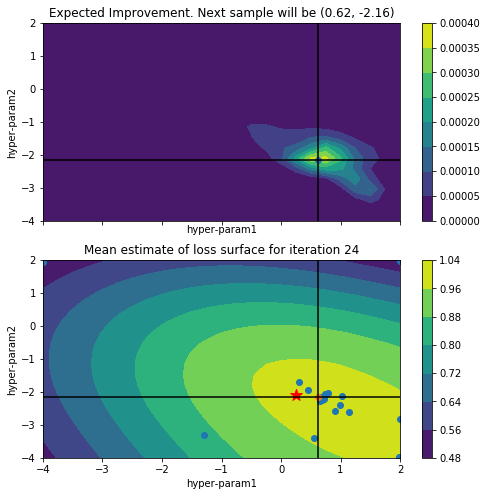

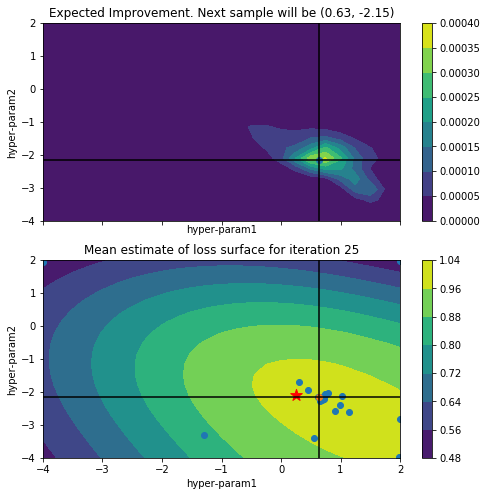

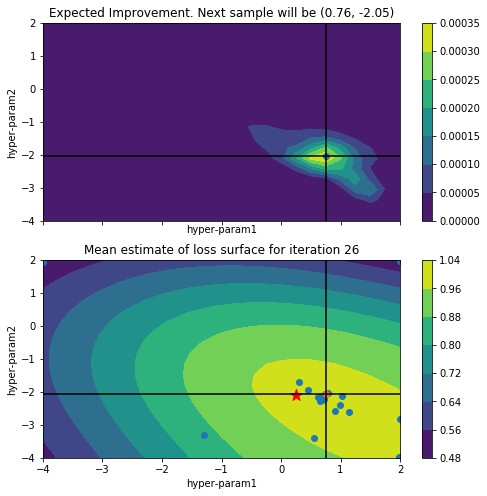

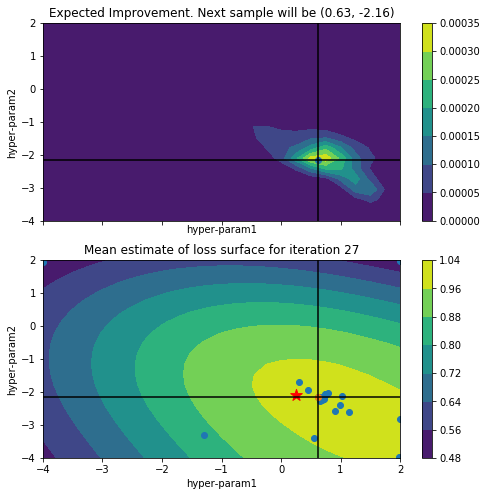

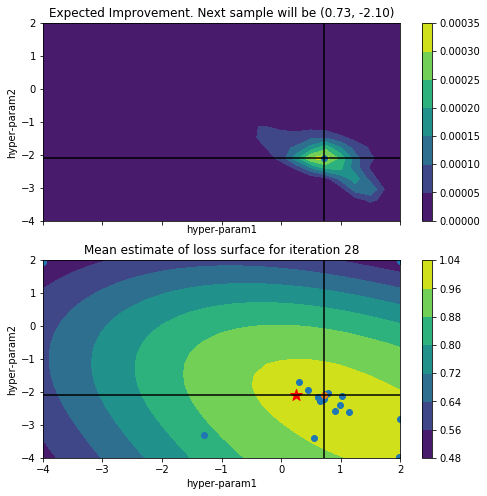

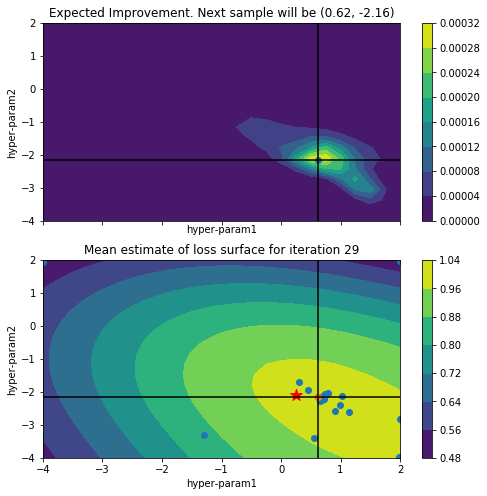

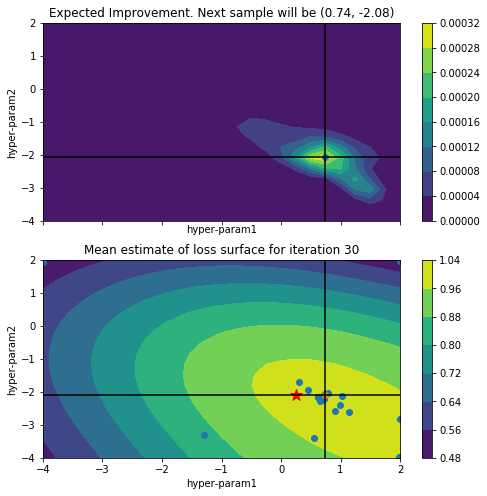

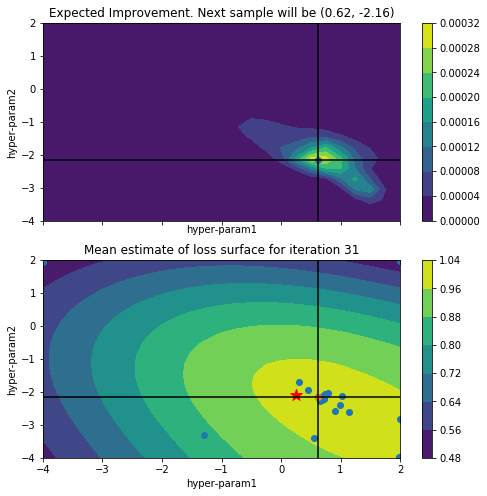

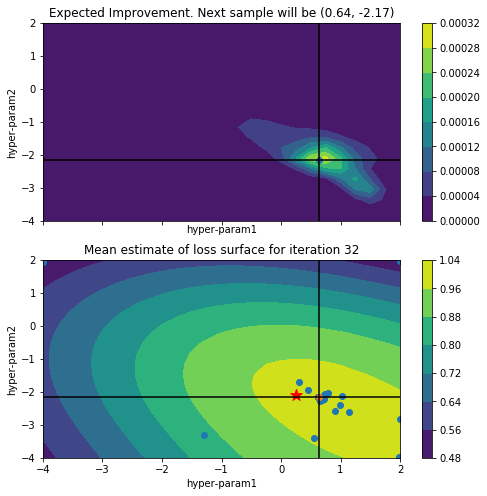

In [18]:
rc('text', usetex=False)

plot_iteration(Cs, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum, filepath='.')

Dans ce cas, on constate une convergence rapide des hyper-paramètres 1 et 2 vers la valeur théorique calculée.

Le leger éccart avec la "valeur théorique" peut s'expliquer par le fait que celle-ci est choisie parmi un nombre limité de valeurs dans une grille de valeurs (donc sujet à approximation).